In [48]:
import numpy as np
from sklearn.preprocessing import StandardScaler
!wget -nc http://www.fredjo.com/files/ihdp_npci_1-100.train.npz
!wget -nc http://www.fredjo.com/files/ihdp_npci_1-100.test.npz 
 
def load_IHDP_data(training_data,testing_data,i=7):
    with open(training_data,'rb') as trf, open(testing_data,'rb') as tef:
        train_data=np.load(trf); test_data=np.load(tef)
        y=np.concatenate(   (train_data['yf'][:,i],   test_data['yf'][:,i])).astype('float32') #most GPUs only compute 32-bit floats
        t=np.concatenate(   (train_data['t'][:,i],    test_data['t'][:,i])).astype('float32')
        x=np.concatenate(   (train_data['x'][:,:,i],  test_data['x'][:,:,i]),axis=0).astype('float32')
        mu_0=np.concatenate((train_data['mu0'][:,i],  test_data['mu0'][:,i])).astype('float32')
        mu_1=np.concatenate((train_data['mu1'][:,i],  test_data['mu1'][:,i])).astype('float32')
 
        data={'x':x,'t':t,'y':y,'t':t,'mu_0':mu_0,'mu_1':mu_1}
        data['t']=data['t'].reshape(-1,1) #we're just padding one dimensional vectors with an additional dimension 
        data['y']=data['y'].reshape(-1,1)
        #rescaling y between 0 and 1 often makes training of DL regressors easier
        data['y_scaler'] = StandardScaler().fit(data['y'])
        data['ys'] = data['y_scaler'].transform(data['y'])
 
    return data
 
data =load_IHDP_data(training_data='./ihdp_npci_1-100.train.npz',testing_data='./ihdp_npci_1-100.test.npz')

X,y, t = data['x'], data['y'], data['t']

File ‘ihdp_npci_1-100.train.npz’ already there; not retrieving.

File ‘ihdp_npci_1-100.test.npz’ already there; not retrieving.



In [1]:
import pandas as pd
data = pd.read_csv("data_processed_arnaud.csv")
data.set_index("Unnamed: 0", drop=True, inplace=True)
data.index.name = None
data = data.dropna()
data


from pickle import load

scaler = load(open('scaler.pkl', 'rb'))

In [55]:
covariates_cols = list(data.columns[:8])#+["treatment"]
outcome = "hospital_expire_flag"
treatment = "treatment"


X = data[covariates_cols].to_numpy(dtype="float32")
t = scaler.transform(data[treatment].to_numpy(dtype="float32").reshape(-1,1))
y = data[outcome].to_numpy(dtype="float32").reshape(-1,1)


In [56]:
n_treatment = 10
t = (t*(n_treatment-1)).astype("int")

In [57]:
from tarNET import tarNET
import tensorflow as tf

normalizer_layer = tf.keras.layers.Normalization(axis=None)
normalizer_layer.adapt(X)

In [58]:
DATASET_SIZE = len(data)

batch_size = 64

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.2 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

dataset = tf.data.Dataset.zip(
    (tf.data.Dataset.from_tensor_slices((X, t)), tf.data.Dataset.from_tensor_slices(y))
).shuffle(buffer_size=DATASET_SIZE, reshuffle_each_iteration=False)#batch(64)

train_dataset = dataset.take(train_size).batch(batch_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.take(val_size).batch(batch_size)
test_dataset = test_dataset.skip(val_size)


Declare the model with correct initial bias

In [59]:
import numpy as np

neg, pos = np.bincount(np.concatenate([y for _, y in train_dataset]).reshape(-1).astype("int"))

initial_bias = tf.keras.initializers.Constant(np.log([pos/neg]))
print(f"{pos/neg*100} percent of the samples are positive")

20.85314886871307 percent of the samples are positive


In [64]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * ((neg+pos) / 2.0)
weight_for_1 = (1 / pos) * ((neg+pos) / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.60
Weight for class 1: 2.90


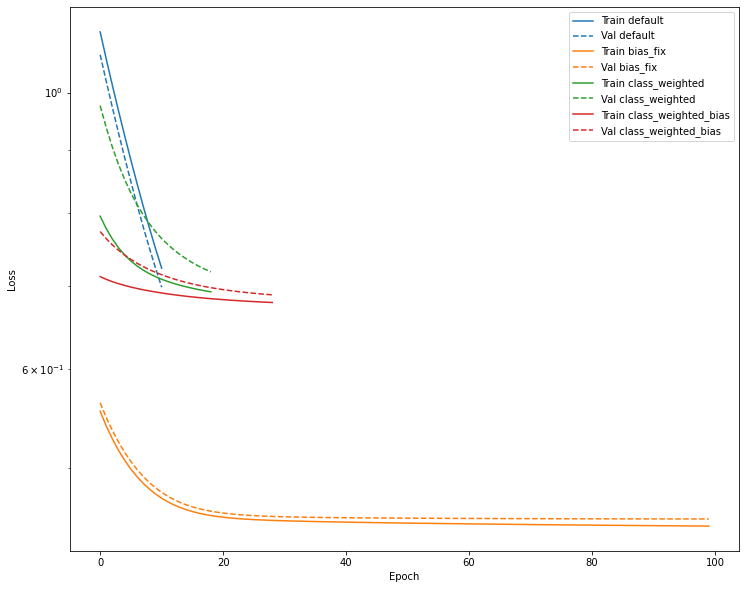

In [68]:
EPOCHS = 100
BATCH_SIZE = 2048

metrics = [
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(name="auc"),
    tf.keras.metrics.AUC(name="prc", curve="PR"),
]

model = tarNET(
    output_dim=1, n_treatments=10, normalizer_layer=normalizer_layer, scaler=scaler
)

model_weighted = tarNET(
    output_dim=1, n_treatments=10, normalizer_layer=normalizer_layer, scaler=scaler
)
model_bias = tarNET(
    output_dim=1,
    n_treatments=10,
    normalizer_layer=normalizer_layer,
    scaler=scaler,
    output_bias=initial_bias,
)

model_bias_weighted = tarNET(
    output_dim=1,
    n_treatments=10,
    normalizer_layer=normalizer_layer,
    scaler=scaler,
    output_bias=initial_bias,
)

models = {"default": model, "bias_fix": model_bias, "class_weighted": model_weighted, "class_weighted_bias": model_weighted}

callbacks = [
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_prc", verbose=1, patience=10, mode="max", restore_best_weights=True
    ),
]

for model in models.values():
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics,
    )


history_ = {
    key: model.fit(
        train_dataset,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks,
        validation_data=val_dataset,
        class_weight=class_weight if "weighted" in key else None,
    )
    for key, model in models.items()
}


from IPython.display import clear_output

clear_output()
import matplotlib as mpl

mpl.rcParams["figure.figsize"] = (12, 10)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]


def plot_loss(history_):
    # Use a log scale on y-axis to show the wide range of values.
    for n, (label, history) in enumerate(history_.items()):
        plt.semilogy(
            history.epoch,
            history.history["loss"],
            color=colors[n],
            label="Train " + label,
        )
        plt.semilogy(
            history.epoch,
            history.history["val_loss"],
            color=colors[n],
            label="Val " + label,
            linestyle="--",
        )
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
    plt.legend()


plot_loss(history_)
# plot_loss(careful_bias_history, "Careful Bias", 1)

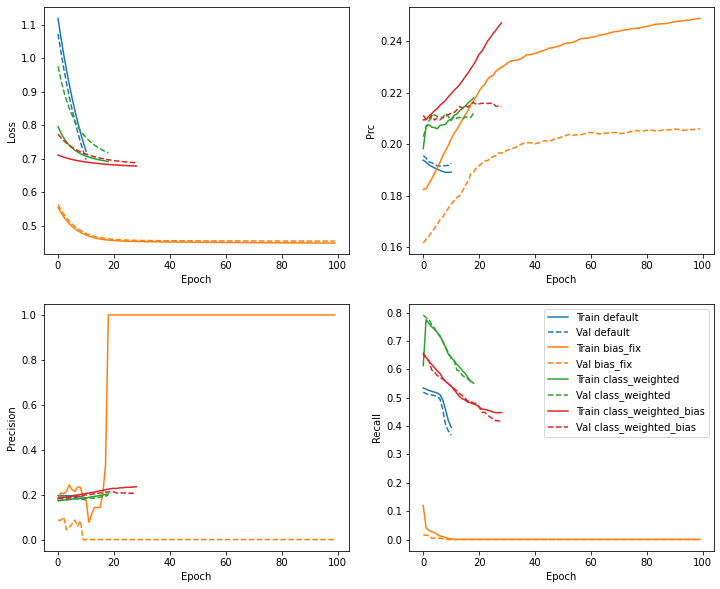

In [69]:
def plot_metrics(history_):

    metrics = ["loss", "prc", "precision", "recall"]
    for color_index, (model_name, history) in enumerate(history_.items()):
        for n, metric in enumerate(metrics):
            name = metric.replace("_", " ").capitalize()
            plt.subplot(2, 2, n + 1)
            plt.plot(
                history.epoch,
                history.history[metric],
                color=colors[color_index],
                label=f"Train {model_name}",
            )
            plt.plot(
                history.epoch,
                history.history["val_" + metric],
                color=colors[color_index],
                linestyle="--",
                label=f"Val {model_name}",
            )
            plt.xlabel("Epoch")
            plt.ylabel(name)
            #if metric == "loss":
            #    plt.ylim([0, plt.ylim()[1]])
            #elif metric == "auc":
            #    plt.ylim([0.8, 1])
            #else:
            #    plt.ylim([0, 1])

        plt.legend()


plot_metrics(history_)

loss :  0.6122579574584961
tp :  14.0
fp :  30.0
tn :  981.0
fn :  174.0
accuracy :  0.8298582434654236
precision :  0.3181818127632141
recall :  0.07446808367967606
auc :  0.5234994292259216
prc :  0.19724419713020325



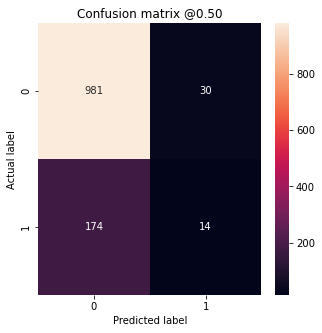

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


train_predictions_baseline = model.predict(train_dataset, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_dataset, batch_size=BATCH_SIZE)

train_labels=np.concatenate([y for _,y in train_dataset])
test_labels=np.concatenate([y for _,y in test_dataset])


def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
baseline_results = model.evaluate(test_dataset,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()


plot_cm(test_labels, test_predictions_baseline)

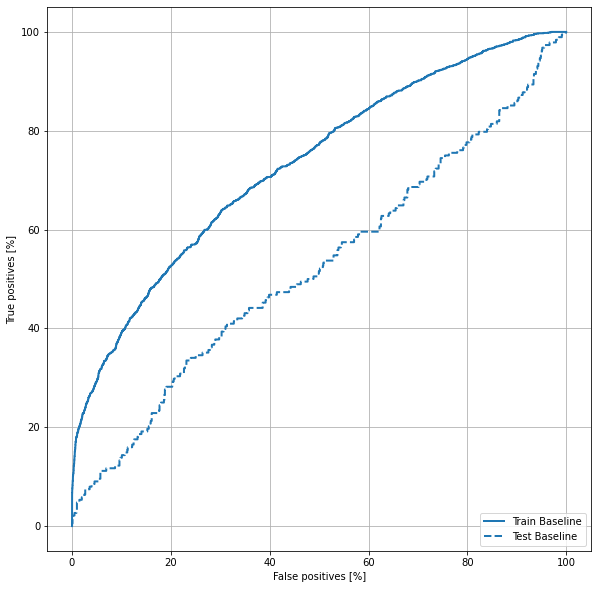

In [40]:
from sklearn.metrics import roc_curve
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    #plt.xlim([-0.5,20])
    #plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')